In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import chi2_contingency
#wrapper methods
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#scaler methods
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# embedded methods
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

# Importing the Csv's for modeling

In [2]:
X_train_binary_1 = pd.read_csv('https://raw.githubusercontent.com/Sebastiao199/Project_Group18_ML/main/Csv_after_cleaning/X_train_binary_1.csv', index_col='encounter_id')
X_val_binary_1 = pd.read_csv('https://raw.githubusercontent.com/Sebastiao199/Project_Group18_ML/main/Csv_after_cleaning/X_val_binary_1.csv', index_col='encounter_id')
y_train_binary_1 = pd.read_csv('https://raw.githubusercontent.com/Sebastiao199/Project_Group18_ML/main/Csv_after_cleaning/y_train_binary_1.csv', index_col='encounter_id')
y_val_binary_1 = pd.read_csv('https://raw.githubusercontent.com/Sebastiao199/Project_Group18_ML/main/Csv_after_cleaning/y_val_binary_1.csv', index_col='encounter_id')

In [3]:
X_train_binary_1.columns = X_train_binary_1.columns.str.replace('[ ,]', '_', regex=True)
X_val_binary_1.columns = X_val_binary_1.columns.str.replace('[ ,]', '_', regex=True)

In [4]:
X_train_binary_1.columns

Index(['race_AfricanAmerican', 'race_Caucasian', 'race_Other', 'payer_code_HM',
       'payer_code_MC', 'payer_code_None', 'payer_code_Other_code',
       'admission_type_Elective', 'admission_type_Emergency',
       'admission_type_Other_type', 'admission_type_Urgent',
       'medical_specialty_Cardiology', 'medical_specialty_Emergency_Trauma',
       'medical_specialty_Family_GeneralPractice',
       'medical_specialty_InternalMedicine',
       'medical_specialty_Other_specialty', 'medical_specialty_Surgery',
       'discharge_disposition_Discharged_to_home',
       'discharge_disposition_Discharged_transferred_referred_another_this_institution_for_outpatient_services',
       'discharge_disposition_Expired', 'discharge_disposition_Other',
       'discharge_disposition_Transferred_to_another_medical_facility',
       'discharge_disposition_Unknown', 'admission_source_Emergency_Room',
       'admission_source_Other_source', 'admission_source_Physician_Referral',
       'primary_diagno

# Feature Selection

Previous used columns:
'discharge_disposition_Discharged to home', 'inpatient_visits', 'outpatient_visits', 'emergency_visits', 'number_diagnoses',
'diabetes_meds_binary', 'average_pulse_bpm', 'number_of_medications', 'number_lab_tests', 'Midpoint_Age'

### Univariate Methods

In [5]:
numeric_columns = ['outpatient_visits','emergency_visits', 'inpatient_visits', 'average_pulse_bpm', 'length_of_stay', 
                   'number_lab_tests', 'non_lab_procedures','number_of_medications', 'number_diagnoses', 'number_prescriptions',
                   'Midpoint_Age']

In [6]:
X_train_binary_1[numeric_columns].var()

outpatient_visits          1.658062
emergency_visits           0.880346
inpatient_visits           1.609366
average_pulse_bpm        530.336335
length_of_stay             8.975235
number_lab_tests         384.826582
non_lab_procedures         2.909965
number_of_medications     65.495039
number_diagnoses           3.736187
number_prescriptions       0.845097
Midpoint_Age             245.935704
dtype: float64

Since the is no variance equal to 0, then there is no numerical variable that is univariate. With that in mind, we don´t need to drop any column. Adding to this, we can say that there are some numerical variables with high variance like Midpoint_Age, number_lab_tests and average_pulse_bpm (we could also say number_of_medications), and some with low variance like emergency_visits and number_prescriptions.

### Correlation indices

In [7]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [8]:
cor_spearman = X_train_binary_1[numeric_columns].corr(method ='spearman')
cor_spearman

,outpatient_visits,emergency_visits,inpatient_visits,average_pulse_bpm,length_of_stay,number_lab_tests,non_lab_procedures,number_of_medications,number_diagnoses,number_prescriptions,Midpoint_Age
outpatient_visits,1.000000,0.178239,0.154406,0.003741,-0.011900,-0.021399,-0.026964,0.071612,0.111438,0.004986,0.024640
emergency_visits,0.178239,1.000000,0.216654,0.000970,-0.003668,0.006584,-0.043619,0.042457,0.088748,0.015773,-0.053773
inpatient_visits,0.154406,0.216654,1.000000,0.003707,0.090804,0.041561,-0.067057,0.098296,0.135500,-0.016267,0.016056
average_pulse_bpm,0.003741,0.000970,0.003707,1.000000,0.001537,-0.001670,-0.004411,0.003625,-0.001355,0.000337,0.006627
length_of_stay,-0.011900,-0.003668,0.090804,0.001537,1.000000,0.333035,0.190399,0.462737,0.240230,0.086590,0.122734
number_lab_tests,-0.021399,0.006584,0.041561,-0.001670,0.333035,1.000000,0.018434,0.246450,0.172129,0.028189,0.028675
non_lab_procedures,-0.026964,-0.043619,-0.067057,-0.004411,0.190399,0.018434,1.000000,0.348313,0.069969,-0.008855,-0.063130
number_of_medications,0.071612,0.042457,0.098296,0.003625,0.462737,0.246450,0.348313,1.000000,0.296157,0.237336,0.028013
number_diagnoses,0.111438,0.088748,0.135500,-0.001355,0.240230,0.172129,0.069969,0.296157,1.000000,0.014665,0.194423
number_prescriptions,0.004986,0.015773,-0.016267,0.000337,0.086590,0.028189,-0.008855,0.237336,0.014665,1.000000,-0.007739


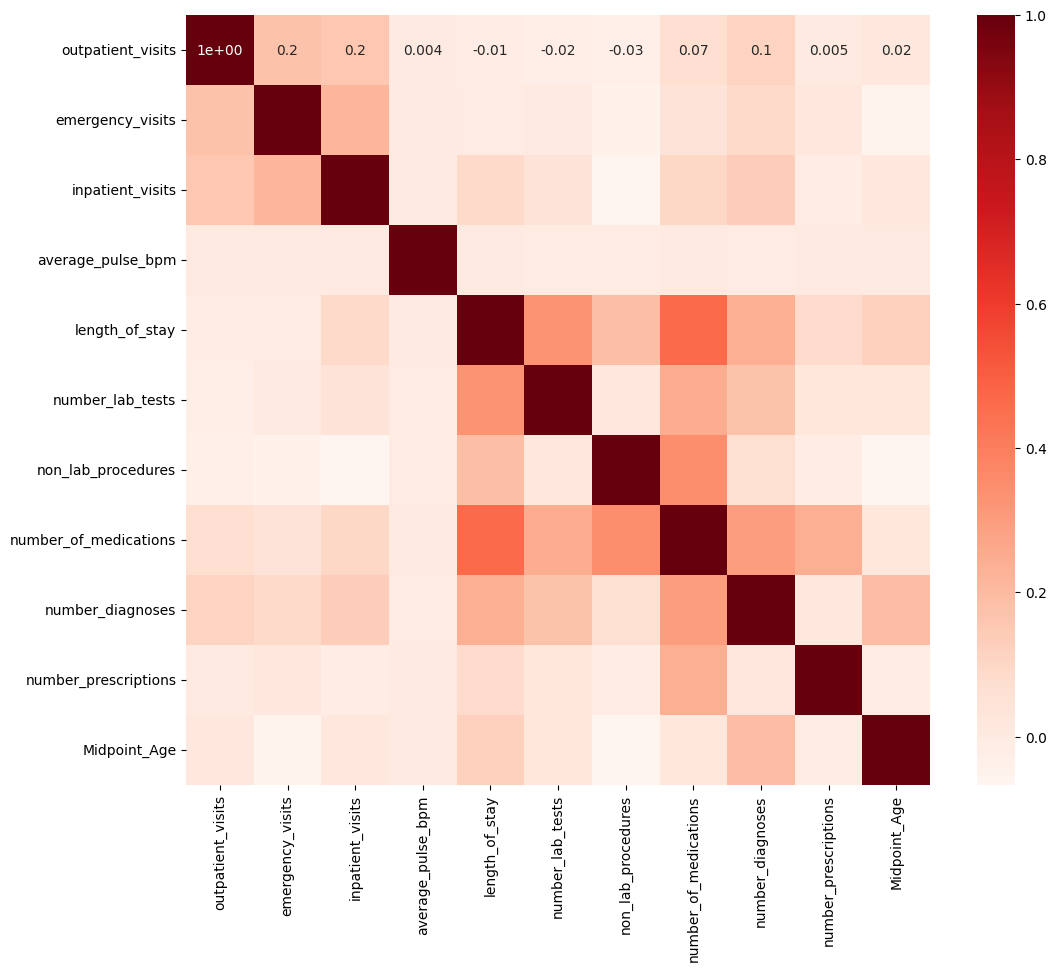

In [9]:
cor_heatmap(cor_spearman)

We can conclude that:
- We need to use other feature selection techniques to get more insights.
- There is one pair of variables that is significantly correlated:
    - length_of_stay vs number_of_medications (0.5) <br>

### Chi-square

- 'race_AfricanAmerican', 'race_Caucasian', 'race_Other';
- 'payer_code_HM','payer_code_MC', 'payer_code_None', 'payer_code_Other_code';
- 'admission_type_Elective','admission_type_Emergency','admission_type_Other_type','admission_type_Urgent','medical_specialty_Cardiology';
- 'medical_specialty_Emergency/Trauma','medical_specialty_Family/GeneralPractice','medical_specialty_InternalMedicine','medical_specialty_Other_specialty', 'medical_specialty_Surgery';
- 'discharge_disposition_Discharged to home','discharge_disposition_Expired', 'discharge_disposition_Other','discharge_disposition_Transferred to another medical facility','discharge_disposition_Unknown';
- 'admission_source_ Emergency Room','admission_source_ Physician Referral', 'admission_source_Other_source';
- 'primary_diagnosis_types_Diseases of the circulatory system','primary_diagnosis_types_Diseases of the digestive system','primary_diagnosis_types_Diseases of the respiratory system','primary_diagnosis_types_External causes of injury and supplemental classification','primary_diagnosis_types_Injury and poisoning','primary_diagnosis_types_Other_type','primary_diagnosis_types_Symptoms, signs, and ill-defined conditions';
- 'secondary_diagnosis_types_Diseases of the circulatory system','secondary_diagnosis_types_Diseases of the genitourinary system','secondary_diagnosis_types_Diseases of the respiratory system','secondary_diagnosis_types_Endocrine, nutritional and metabolic diseases, and immunity disorders','secondary_diagnosis_types_External causes of injury and supplemental classification','secondary_diagnosis_types_Other_type';
- 'additional_diagnosis_types_Diseases of the circulatory system','additional_diagnosis_types_Diseases of the genitourinary system','additional_diagnosis_types_Diseases of the respiratory system','additional_diagnosis_types_Endocrine, nutritional and metabolic diseases, and immunity disorders','additional_diagnosis_types_External causes of injury and supplemental classification','additional_diagnosis_types_Other_type';
- 'glucose_test_result_>200','glucose_test_result_>300', 'glucose_test_result_None', 'glucose_test_result_Norm';
- 'a1c_test_result_>7', 'a1c_test_result_>8','a1c_test_result_None', 'a1c_test_result_Norm';
- 'diabetes_meds_binary', 'change_in_meds_binary','is_normal_pulse', 'medication', 'gender_binary';
These were the columns that were considered important (the ones not here were discarted)

### Visualize the weight of the dependent variable in categorical data

Based on the visualizations we have seen on the Cleaning&PreProcessing notebook (we in the future will merge the notebooks, but I think putting every visualization here will fill too much this notebook), these are the conclusions we take:

Columns that are not correlated with the target: 

- medication
- admission_type (maybe Emergency a bit)
- admission_source (maybe Emergency_room a bit)
- is_normal_pulse
- average_pulse_bpm
- gender_binary
- number_lab_tests
- number_prescriptions

Columns that have some correlation with the target: 

- race (other)
- MidPointAge
- discharge_disposition (Expired, Other, Transferred to another medical facility)
- medical_specialty (Cardiology)
- primary_diagnosis_types (Endocrine, nutritional and metabolic diseases, and immunity disorders, Injury and poisoning)
- secondary_diagnosis_types (Endocrine, nutritional and metabolic diseases, and immunity disorders, External causes of injury and supplemental classification)
- additional_diagnosis_types (Endocrine, nutritional and metabolic diseases, and immunity disorders, Diseases of the genitourinary system)
- glucose_test_result (>300)
- a1c_test_result (None)
- diabetes_meds_binary
- change_in_meds_binary
- length_of_stay
- non_lab_procedures
- number_of_medications
- number_diagnoses
- emergency_visits
- inpatient_visits


Maybe yes/Maybe no: 

- payer_code
- outpatient_visits


### Point Biserial Correlation

More than 0.01 Corr: 
- length_of_stay
- number_lab_tests 
- non_lab_procedures 
- number_of_medications 
- number_diagnoses 
- outpatient_visits 
- emergency_visits 
- inpatient_visits

## Final result (Features choosen)

In [10]:
selected_features=['race_Other','Midpoint_Age','discharge_disposition_Expired','discharge_disposition_Other',
                   'discharge_disposition_Transferred_to_another_medical_facility','medical_specialty_Cardiology',
                   'primary_diagnosis_types_External_causes_of_injury_and_supplemental_classification',
                   'primary_diagnosis_types_Injury_and_poisoning','secondary_diagnosis_types_Endocrine_nutritional_and_metabolic_diseases_and_immunity_disorders',
                   'secondary_diagnosis_types_External_causes_of_injury_and_supplemental_classification',
                   'additional_diagnosis_types_Endocrine_nutritional_and_metabolic_diseases_and_immunity_disorders',
                   'additional_diagnosis_types_Diseases_of_the_genitourinary_system','glucose_test_result_>300',
                   'a1c_test_result_None','diabetes_meds_binary','change_in_meds_binary','length_of_stay','non_lab_procedures',
                   'number_of_medications','number_diagnoses','emergency_visits','inpatient_visits','discharge_disposition_Discharged_to_home']

In [11]:
len(selected_features)

23

# Normalization Methods

In [16]:
X_train_binary_1 = X_train_binary_1[selected_features]
X_val_binary_1 = X_val_binary_1[selected_features]

In [20]:
# Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_binary_1)
X_val_scaled = scaler.transform(X_val_binary_1)

In [21]:
# Min Max Scaler
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train_binary_1)
X_val_minmax = min_max_scaler.transform(X_val_binary_1)

In [22]:
# Min Max Scaler between -1 and 1
min_max_scaler_neg1_1 = MinMaxScaler(feature_range=(-1, 1))
X_train_minmax_neg1_1 = min_max_scaler_neg1_1.fit_transform(X_train_binary_1)
X_val_minmax_neg1_1 = min_max_scaler_neg1_1.transform(X_val_binary_1)

In [23]:
# Robust Scaler
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train_binary_1)
X_val_robust = robust_scaler.transform(X_val_binary_1)

# Imbalanced Learning

Cost-sensitive learning: This involves assigning a higher cost to misclassifying minority classes.

In [24]:
y_train_binary_1.value_counts(normalize=True)

readmitted_binary
No                   0.88839
Yes                  0.11161
Name: proportion, dtype: float64

In [25]:
y_val_binary_1.value_counts(normalize=True)

readmitted_binary
No                   0.888427
Yes                  0.111573
Name: proportion, dtype: float64

### SMOTE

Until now the best scores where always with **Robust Scaler** (because of the outliers) so we are going to try all the models with **only Robust Scaler** (for efficiency of time). We can try another option, which would be, handling the outilers (some or all), check the scores with Standard Scaler and/or Min Max Scaler and then compare this scores with the ones we got from Robust Scaler before handling the outliers.

In [26]:
y_train_binary_1 = y_train_binary_1[y_train_binary_1.columns[0]].map({'Yes': 1, 'No': 0})
y_val_binary_1 = y_val_binary_1[y_val_binary_1.columns[0]].map({'Yes': 1, 'No': 0})

In [27]:
print("Number transactions X_train dataset: ", X_train_binary_1.shape)
print("Number transactions y_train dataset: ", y_train_binary_1.shape)
print("Number transactions X_val dataset: ", X_val_binary_1.shape)
print("Number transactions y_val dataset: ", y_val_binary_1.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train_binary_1==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_binary_1==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train_robust, y_train_binary_1.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Number transactions X_train dataset:  (53427, 23)
Number transactions y_train dataset:  (53427,)
Number transactions X_val dataset:  (17809, 23)
Number transactions y_val dataset:  (17809,)
Before OverSampling, counts of label '1': 5963
Before OverSampling, counts of label '0': 47464 

After OverSampling, the shape of train_X: (94928, 23)
After OverSampling, the shape of train_y: (94928,) 

After OverSampling, counts of label '1': 47464
After OverSampling, counts of label '0': 47464


# Algorithms

In [ ]:
# Define the models
models = [
    ('dt', DecisionTreeClassifier(random_state=19)),
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(random_state=19))
]

# Define the hyperparameters  
hyperparameters = [
    {
        'dt__criterion': ['gini', 'entropy'],
        'dt__splitter': ['best'],
        'dt__max_depth': [5, 10, 15],
        'dt__min_samples_split': [50, 100, 150, 200],
        'dt__min_samples_leaf': [5, 25, 50, 100]
    }, # Decision Tree
    {
        'knn__n_neighbors': [75, 150, 250, 300],
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['auto'],
    }, # K Nearest Neighbors
    {
        'rf__n_estimators': [10, 50, 75, 100],
        'rf__criterion': ['gini', 'entropy'],
        'rf__max_depth': [2, 5, 10],
        'rf__min_samples_split': [2, 10, 50, 100],
        'rf__min_samples_leaf': [1, 5, 10, 15]
    } # Random Forest
]

# Initialize an empty list to store the results
results = []

# Loop over each model
for model, params in zip(models, hyperparameters):
    # Create a pipeline with SMOTE and the model
    pipeline = ImbPipeline([('SMOTE', SMOTE(random_state=42)), model])
    
    # Initialize GridSearchCV
    gs = GridSearchCV(pipeline, params, scoring='f1', verbose=10)
    
    # Fit GridSearchCV
    gs.fit(X_train_robust, y_train_binary_1)
    
    # Append the best score and best parameters to the results list
    results.append([gs.best_score_, gs.best_params_])

# Convert the results list to a DataFrame and sort by the best score
test_scores_df = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_df = test_scores_df.sort_values('best_score', ascending=False)

In [ ]:
test_scores_df

In [43]:
print(test_scores_df['best_params'][2])
print(test_scores_df['best_params'][0])
print(test_scores_df['best_params'][1])

{'rf__n_estimators': 100, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 5, 'rf__max_depth': 5, 'rf__criterion': 'entropy', 'rf__bootstrap': False}
{'dt__splitter': 'best', 'dt__min_samples_split': 2, 'dt__min_samples_leaf': 2, 'dt__max_depth': 5, 'dt__criterion': 'entropy'}
{'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 9, 'knn__algorithm': 'kd_tree'}


In [ ]:
test_scores_df.to_csv('test_scores_df_restart_3.csv', index = False, encoding='utf-8')

### Gradient & SVM

In [ ]:
# Define the models
models = [
    ('gbc', GradientBoostingClassifier())
]

# Define the hyperparameters  
hyperparameters = [
    {
        'gbc__n_estimators': [100],'gbc__max_depth': [None,1],'gbc__min_samples_split': [2],
        'gbc__min_samples_leaf': [20],'gbc__learning_rate': [0.01],'gbc__subsample':[0.5,0.75,1.0]
    }
                  ]

# Initialize an empty list to store the results
results = []

# Loop over each model
for model, params in zip(models, hyperparameters):
    # Create a pipeline with SMOTE and the model
    pipeline = ImbPipeline([('SMOTE', SMOTE(random_state=42)), model])
    
    # Initialize GridSearchCV
    gs = GridSearchCV(pipeline, params, scoring='f1', verbose=3)
    
    # Fit GridSearchCV
    gs.fit(X_train_robust, y_train_binary_1)
    
    # Append the best score and best parameters to the results list
    results.append([gs.best_score_, gs.best_params_])

# Convert the results list to a DataFrame and sort by the best score
test_scores_df = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_df = test_scores_df.sort_values('best_score', ascending=False)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END gbc__learning_rate=0.01, gbc__max_depth=None, gbc__min_samples_leaf=20, gbc__min_samples_split=2, gbc__n_estimators=100, gbc__subsample=0.5;, score=0.093 total time=  36.8s
[CV 2/5] END gbc__learning_rate=0.01, gbc__max_depth=None, gbc__min_samples_leaf=20, gbc__min_samples_split=2, gbc__n_estimators=100, gbc__subsample=0.5;, score=0.098 total time=  36.7s
[CV 3/5] END gbc__learning_rate=0.01, gbc__max_depth=None, gbc__min_samples_leaf=20, gbc__min_samples_split=2, gbc__n_estimators=100, gbc__subsample=0.5;, score=0.088 total time=  36.7s
[CV 4/5] END gbc__learning_rate=0.01, gbc__max_depth=None, gbc__min_samples_leaf=20, gbc__min_samples_split=2, gbc__n_estimators=100, gbc__subsample=0.5;, score=0.103 total time=  37.3s
[CV 5/5] END gbc__learning_rate=0.01, gbc__max_depth=None, gbc__min_samples_leaf=20, gbc__min_samples_split=2, gbc__n_estimators=100, gbc__subsample=0.5;, score=0.117 total time=  37.0s
[CV 1/5] E

In [ ]:
test_scores_df

In [ ]:
test_scores_df.to_csv('test_scores_df_restart_gb_3.csv', index = False, encoding='utf-8')

In [ ]:
# Define the models
models = [
    ('svc', SVC())
]

# Define the hyperparameters  
hyperparameters = [
    {
        'svc__C': [0.1, 1, 10],'svc__kernel': ['linear', 'rbf'],'svc__gamma': ['scale', 'auto']
    }
                  ]

# Initialize an empty list to store the results
results = []

# Loop over each model
for model, params in zip(models, hyperparameters):
    # Create a pipeline with SMOTE and the model
    pipeline = ImbPipeline([('SMOTE', SMOTE(random_state=42)), model])
    
    # Initialize GridSearchCV
    gs = RandomizedSearchCV(pipeline, params, scoring='f1', verbose=3)
    
    # Fit GridSearchCV
    gs.fit(X_train_robust, y_train_binary_1)
    
    # Append the best score and best parameters to the results list
    results.append([gs.best_score_, gs.best_params_])

# Convert the results list to a DataFrame and sort by the best score
test_scores_df = pd.DataFrame(results, columns=['best_score', 'best_params'])
test_scores_df = test_scores_df.sort_values('best_score', ascending=False)

In [ ]:
test_scores_df

In [ ]:
# test_scores_df.to_csv('test_scores_df_restart_svc_1.csv', index = False, encoding='utf-8')